In [1]:
import keras
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
Inputs = pd.read_csv('Data_Folder/Demo5_22/5_22_ALL.csv',delimiter=',',header=0,index_col=0)
Wearable = pd.read_csv('Data_Folder/Demo5_22/5_22_wearable_processed.csv',delimiter=',',header=0,index_col=0)
#Weather.columns=['DTime','Bar','TempIn','HumIn','TempOut','Wind','Wind10','Wdir','HumOut','RainRate','UV','Solar']

IOError: File Data_Folder/Demo5_22/5_22_ALL.csv does not exist

In [ ]:
Wearable.drop(columns=['Timestamp'], inplace=True)
Wearable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Inputs, Wearable, test_size = 0.2, random_state = 0)


In [ ]:
GPS_label_train = pd.DataFrame(X_train.iloc[:,-2:])
GPS_label_test = pd.DataFrame(X_test.iloc[:,-2:])
X_train.drop(X_train.columns[-2:],axis=1,inplace=True)
X_test.drop(X_test.columns[-2:],axis=1,inplace=True)

In [ ]:
X_train.shape

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_weather = X_train[:,:10]
X_train_stationary = X_train[:,10:]

X_test_weather = X_test[:,:10]
X_test_stationary = X_test[:,10:]


In [ ]:
X_train_weather.shape, X_train_stationary.shape,GPS_label_train.shape, y_train.shape

In [ ]:
inputs_weather = Input(shape=(10,),name='weather')
# weather model
x1 = Dense(32, activation='relu',name='wea_layer_1')(inputs_weather)
x1 = Dense(32, activation='relu',name='wea_layer_2')(x1)
x1 = Dense(32, activation='relu',name='wea_layer_3')(x1)
out_x1 = Dense(6,activation='relu',name='weather_output')(x1)
#model1 = Model(inputs=inputs_weather, outputs=out_x1)


inputs_stationary = Input(shape=(6,),name='stationary')
# stationary model
x2 = Dense(32, activation='relu',name='stat_layer_1')(inputs_stationary)
x2 = Dense(32, activation='relu',name='stat_layer_2')(x2)
x2 = Dense(32, activation='relu',name='stat_layer_3')(x2)
out_x2 = Dense(6,activation='relu',name='stationary_output')(x2)
#model2 = Model(inputs=inputs_stationary, outputs=out_x2)

#GPS_input = Input(shape=(3,),name='GPS_value')
GPS_label = Input(shape=(2,),name='GPS_label')
#middle_layer = concatenate([out_x1,out_x2,GPS_input,GPS_label],axis=1)
middle_layer = concatenate([out_x1,out_x2,GPS_label],axis=1)

# merge models
x = Dense(32, activation='relu', name='weighted')(middle_layer)
main_out = Dense(6, activation='relu',name='main_output')(x)

merged_model = Model(inputs=[inputs_weather,inputs_stationary,GPS_label], outputs=[main_out])

sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
merged_model.compile(loss='mean_squared_error', optimizer=adadelta)
#history = merged_model.fit([X_train_weather, X_train_stationary,X_train_GPS,GPS_label_train], y_train, validation_data=([X_train_weather, X_train_stationary,X_train_GPS,GPS_label_train], y_train), batch_size=16, epochs=5000)
history = merged_model.fit([X_train_weather, X_train_stationary,GPS_label_train], y_train, validation_data=([X_train_weather, X_train_stationary,GPS_label_train], y_train), batch_size=16, epochs=200)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import plot_model
plot_model(merged_model, to_file='model.png')

In [ ]:
#y_pred = merged_model.predict([X_test_weather,X_test_stationary,X_test_GPS, GPS_label_test])
y_pred = merged_model.predict([X_test_weather,X_test_stationary, GPS_label_test])

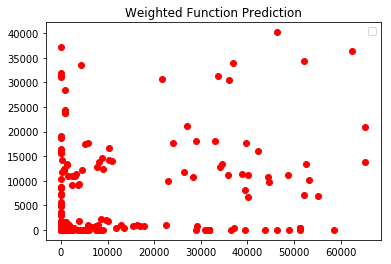

In [129]:
plt.scatter(y_test,y_pred, color = 'red')
plt.title('Weighted Function Prediction')
plt.legend()
plt.show()

In [130]:
mse = mean_squared_error(y_test, y_pred)
print mse

165555488.753149
